# Gibbs Sampler for Bayesian GMM 

### The Target Distribution

Recall that in our model, we suppose that our data, $\mathbf{X}=\{\mathbf{x}_1, \ldots, \mathbf{x}_N\}$ is drawn from the mixture of $K$ number of Gaussian distributions. $X$ has D elements. For each observation $\mathbf{x}_n$ we have a latent variable $\mathbf{z}_n$ that is a 1-of-$K$ binary vector with elements $z_{nk}$. We denote the set of latent variable by $\mathbf{Z}$. Recall that the distribution of $\mathbf{Z}$ given the mixing coefficients, $\pi$, is given by
\begin{align}
p(\mathbf{Z} | \pi) = \prod_{n=1}^N \prod_{k=1}^K \pi_k^{z_{nk}} 
\end{align}
Recall also that the likelihood of the data is given by,
\begin{align}
p(\mathbf{X} | \mathbf{Z}, \mu, \Sigma) =\prod_{n=1}^N \prod_{k=1}^K \mathcal{N}\left(\mathbf{x}_n| \mu_k, \Sigma_k\right)^{z_{nk}}
\end{align}
Finally, in our basic model, we choose a Dirichlet prior for $\pi$ 
\begin{align}
p(\pi) = \mathrm{Dir}(\pi | \alpha_0) = C(\alpha_0) \prod_{k=1}^K \pi_k^{\alpha_0 -1},
\end{align}
where $C(\alpha_0)$ is the normalizing constant for the Dirichlet distribution. We also choose a Normal-Inverse-Wishart prior for the mean and the covariance of the likelihood function
\begin{align}
p(\mu, \Sigma) = p(\mu | \Sigma) p(\Sigma) = \prod_{k=1}^K \mathcal{N}\left(\mu_k | \mathbf{m}_0, \mathbf{V}_0\right) IW(\Sigma_k|\mathbf{S}_0, \nu_0).
\end{align}
Thus, the joint distribution of all the random variable is given by
\begin{align}
p(\mathbf{X}, \mathbf{Z}, \pi, \mu, \Sigma) = p(\mathbf{X} | \mathbf{Z}, \mu, \Sigma) p(\mathbf{Z} | \pi) p(\pi) p(\mu | \Sigma) p(\Sigma)
\end{align}

### Gibbs Sampler
The full conditionals are as follows:
1. $p(\mathbf{z}_{n} = \delta(k) | \mathbf{x}_n, \mu, \Sigma, \pi)  \propto \pi_k \mathcal{N}(\mathbf{x}_n | \mu_k, \Sigma_k)$.
2. $p(\pi|\mathbf{Z}) = \mathrm{Dir}(\{ \alpha_k + \sum_{i=1}^N \mathbb{I}(\mathbf{z}_{n} = \delta(k))_{k=1}^K\})$
3. $p(\mu_k | \Sigma_k, \mathbf{Z}, \mathbf{X}) = \mathcal{N}(\mu_k | m_k, V_k)$
4. $\mathbf{V}_k^{-1} = \mathbf{V}_0^{-1} + N_k\Sigma_k^{-1}$
5. $\mathbf{m}_k = \mathbf{V}_k(\Sigma_k^{-1}N_k\overline{\mathbf{x}}_k + \mathbf{V}_0^{-1}\mathbf{m}_0)$
6. $N_k = \sum_{n=1}^N \mathbb{I}(\mathbf{z}_{n} = \delta(k))$
7. $\overline{\mathbf{x}}_k = \displaystyle \frac{\sum_{n=1}^N \mathbb{I}(\mathbf{z}_{n} = \delta(k))\mathbf{x}_n}{N_k}$
8. $p(\Sigma_k | \mu_k, \mathbf{z}, \mathbf{x}) = IW(\Sigma_k | \mathbf{S}_k, \nu_k)$
9. $\mathbf{S}_k = \mathbf{S}_0 + \sum_{n=1}^N \mathbb{I}(\mathbf{z}_{n} = \delta(k))(\mathbf{x}_n - \mu_k)(\mathbf{x}_n - \mu_k)^\top$
10. $\nu_k = \nu_0 + N_k$

The algorithm for the sampler is as follows:
1. Instantiate the latent variables randomly.
2. For $k=1...K$:
    3. For $n=1...N$: update $z_i$ by sampling from $p(\mathbf{z}_{n} = \delta(k) | \mathbf{x}_n, \mu, \Sigma, \pi)$.
    4. Update $\pi$
    5. Update variables for each component 

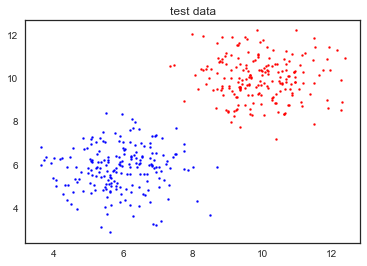

In [341]:

import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set_style("white")

import time
import timeit

import scipy.stats 
import pandas as pd
import pymc as pm
from sklearn import mixture

import re
import numpy as np
#-------------   data parameters
K = 2 #number of components
N = 400 #number of observations
M = 2 #number of attributes per observation

n_samples = int(N/2.0) #number of points in each component
mu1 = np.array([10, 10]) #mean of component 1
mu2 = np.array([6, 6]) #mean of component 1

# generate random sample, two components
np.random.seed(0)

# generate spherical data centered on mu1
comp1 = np.random.randn(n_samples, M) + mu1

# generate spherical data centered on mu2
comp2 = np.random.randn(N - n_samples, M) + mu2

# concatenate the two datasets into training set
data = np.vstack([comp1, comp2])

#plot the components
plt.scatter(comp1[:, 0], comp1[:, 1], 4, color='r')
plt.scatter(comp2[:, 0], comp2[:, 1], 4, color='b')

plt.title('test data')
plt.axis('tight')
plt.show()

In [332]:
from scipy.stats import invwishart, multivariate_normal, dirichlet

# It would be easier to debug if we implement each update separately
def update_Z(X, mu, Sigma, pi):
    """
    X: NxD matrix
    mu: Vector of k elements. Each element is a vector of D elements. 
    Sigma: Vector of k elements. Each element is a DxD covarianc ematrix
    pi: Vector of k scalars
    Returns Z, an NxK matrix made up of 1s and 0s (each row contains a single 1)
    """
    
    N = len(X)
    K = len(mu)
    Z = np.zeros((N,K))

    probs_vector = np.zeros(K)

    for i in range(N):
        for j in range(K):

            probs_vector[j] = pi[j]*multivariate_normal.pdf(X[i], mean = mu[j], cov = Sigma[j])
        normalization = np.sum(probs_vector)
        probs_vector = probs_vector/normalization
        Z[i] = np.random.multinomial(1, probs_vector)     
    
    return Z


def update_N_k(Z):
    """Returns a k-element vector describing number of elements in each cluster"""
    N_k = np.sum(Z, axis = 0)
    
    return N_k

def update_pi(alpha_k, Z):
    """
    alpha_k: Vector of K scalars
    Z: an NxK matrix
    pi: a vector of K scalars
    """
    N_k = np.sum(Z, axis = 0)
    pi = dirichlet.rvs(alpha_k+N_k)
    return np.squeeze(pi)

def update_mean_x_k(Z, X, N_k):
    """
    Average value of observations belonging to cluster k
    mean_x_k: Matrix of dimension KxD
    """
    mean_x_k = np.zeros((len(N_k),len(X[0])))
    for i in range(len(mean_x_k)):
        for j in range(len(Z)):
            mean_x_k[i]+=Z[j][i]*X[j]
        mean_x_k[i] = mean_x_k[i]/N_k[i]

    
    return mean_x_k


def update_nu_k(nu_0, N_k):
    """
    returns a k-element vector
    """

    nu_k = nu_0+N_k

    return nu_k



def update_V_k(V_0, N_k, Sigma_k):
    """
    V_0: DxD matrix
    N_k: Vector of k integers
    Sigma_k: Vector of k elements, each element is a DxD covariance matrix
    V_k: Vector of k elements, each element is a DxD covariance matrix
    """
    V_k = np.zeros_like(Sigma_k)
    V_0_inv = np.linalg.inv(V_0)
    for i in range(len(V_k)):
        inv = V_0_inv+N_k[i]*np.linalg.inv(Sigma_k[i])
        V_k[i] = np.linalg.inv(inv)             
        
    return V_k
    
def update_m_k(V_k, Sigma_k, N_k, mean_x_k, V_0, m_0):
    """
    V_0: DxD matrix
    m_0: Vector of K elements, each element has D elements
    N_k: Vector of k integers
    Sigma_k: Vector of k elements, each element is a DxD covariance matrix
    V_k: Vector of k elements, each element is a DxD covariance matrix
    mean_x_k: DxK matrix describing average values of observations in each cluster
    """
    V_0_inv = np.linalg.inv(V_0)
    m_k = np.zeros((len(N_k), len(m_0)))
    for i in range(len(m_k)):
        Sig_inv = np.linalg.inv(Sigma_k[i])

        m_k[i] = np.dot(V_k[i],(np.dot(Sig_inv,N_k[i]*mean_x_k[i])+np.dot(V_0_inv,m_0)))
    return m_k

def update_mu_k(m_k, V_k):
    """
    m_k: Vector of k elements, each element has a vector with D elements
    V_k: Vector of k elements, each element is a DxD covariance matrix
    mu_k: Vector of k elements, each element has a vector with D elements
    """
    mu_k = np.zeros_like(m_k)

    for i in range(len(mu_k)):
        mu_k[i] = multivariate_normal.rvs(mean = m_k[i], cov = V_k[i])

    return mu_k

def update_S_k(Z, X, mu_k, S_0):
    """
    S_0: DxD matrix
    Scale matrices for inverse wishart distribution
    Returns array of k matrices (DxD)
    """
    S_k = np.zeros((len(mu_k), S_0.shape[0], S_0.shape[1]))
    for j in range(len(mu_k)):
        S_k[j]=np.copy(S_0)
        for i in range(len(Z)):
            S_k[j]+=Z[i][j]*np.outer((X[i]-mu_k[j]),(X[i]-mu_k[j]))
    return S_k

def update_Sigma_k(S_k, nu_k):
    """
    Covariance matrices for the k clusters
    Returns array of k matrices of dimension DxD
    """
    Sigma_k = np.zeros_like(S_k)
    for i in range(len(nu_k)):
        Sigma_k[i] = invwishart.rvs(nu_k[i], S_k[i])
    return Sigma_k

# this function can be reused even when we change the prior on pi 
def gibbs_gmm(K, X, pi, Z, mu, Sigma, nu_0, S_0, V_0, m_0, alpha_0):
    """
    K: number of components
    X: observations
    nu_0: dof for inverse Wishart distribution
    S_0: scale matrix for inverse Wishart distribution
    m_0: Mean of normal-inverse-Wishart distribution
    V_0: Covariance matrix of normal-inverse-Wishart distribution
    alpha_0: parameter for Dirichlet distribution
    """
    numsamples = 500

    Z_samples = np.zeros((numsamples, Z.shape[0], Z.shape[1]))
    mu_samples = np.zeros((numsamples, mu.shape[0], mu.shape[1]))
    pi_samples = np.zeros((numsamples, K))
    Sigma_samples = np.zeros((numsamples, K, Sigma.shape[1], Sigma.shape[2]))
    nu_samples = np.zeros((numsamples, K))
    V_samples = np.zeros((numsamples, K, V_0.shape[0],V_0.shape[1]))
    m_samples = np.zeros((numsamples, K, m_0.shape[0]))
    S_samples = np.zeros_like(Sigma_samples)

    Z_samples[0] = Z
    N_k = update_N_k(Z_samples[0])
    pi_samples[0] = pi
    mean_x_k = update_mean_x_k(Z_samples[0], X, N_k)
    mu_samples[0] = mu
    Sigma_samples[0] = Sigma
    nu_samples[0] = update_nu_k(nu_0, N_k)
    V_samples[0] = update_V_k(V_0, N_k, Sigma_samples[0])
    m_samples[0] = update_m_k(V_samples[0], Sigma_samples[0], N_k, mean_x_k, V_0, m_0)
    print m_samples[0]
    S_samples[0] = update_S_k(Z_samples[0], X, mu_samples[0], S_0)

    for i in range(1,numsamples):
    
        Z_samples[i]= update_Z(X, mu_samples[i-1], Sigma_samples[i-1], pi_samples[i-1])
        N_k = update_N_k(Z_samples[i])
        print i, N_k
        #print "+++"
        pi_samples[i] = update_pi(alpha_0, Z_samples[i])
        mean_x_k = update_mean_x_k(Z_samples[i], X, N_k)
        #if np.isnan(mean_x_k[0][0]) or np.isnan(mean_x_k[1][0]):
        #    print pi_samples[i-1], mu_samples[i-1], Sigma_samples[i-1], N_k
        mu_samples[i] = update_mu_k(m_samples[i-1], V_samples[i-1])
        Sigma_samples[i] = update_Sigma_k(S_samples[i-1], nu_samples[i-1])
        nu_samples[i] = update_nu_k(nu_0, N_k)
        V_samples[i]= update_V_k(V_0, N_k, Sigma_samples[i])
        m_samples[i] = update_m_k(V_samples[i], Sigma_samples[i], N_k, mean_x_k, V_0, m_0)
        S_samples[i] = update_S_k(Z_samples[i], X, mu_samples[i], S_0)

    return Z_samples, pi_samples, mu_samples, Sigma_samples, nu_samples, V_samples, m_samples, S_samples


In [342]:
N = 100
K = 2
X = data
pi = np.array([0.44, 0.55])

Sigma = np.array([np.eye(2), np.eye(2)])

mu = np.array([[11.2, 10.7],[5.3, 6.5]]) 
Z  = update_Z(data, mu, Sigma, pi)

nu_0 = 2
S_0 = np.eye(2)
V_0 =  np.eye(2)
m_0 = np.array([8., 8.])  
alpha_0 = np.array([1., 1.])



Z_samples, pi_samples, mu_samples, Sigma_samples, nu_samples, V_samples, m_samples, S_samples= gibbs_gmm(K, 
                                                                                                         X, 
                                                                                                         pi, 
                                                                                                         Z, 
                                                                                                         mu, 
                                                                                                         Sigma, 
                                                                                                         nu_0, 
                                                                                                         S_0, 
                                                                                                         V_0, 
                                                                                                         m_0, 
                                                                                                         alpha_0)



[[  9.94290529  10.02034371]
 [  5.93828041   5.92667786]]
1 [ 198.  202.]
2 [ 204.  196.]
3 [ 200.  200.]
4 [ 201.  199.]
5 [ 201.  199.]
6 [ 200.  200.]
7 [ 200.  200.]
8 [ 200.  200.]
9 [ 200.  200.]
10 [ 199.  201.]
11 [ 200.  200.]
12 [ 201.  199.]
13 [ 200.  200.]
14 [ 200.  200.]
15 [ 200.  200.]
16 [ 200.  200.]
17 [ 200.  200.]
18 [ 200.  200.]
19 [ 200.  200.]
20 [ 200.  200.]
21 [ 200.  200.]
22 [ 201.  199.]
23 [ 201.  199.]
24 [ 200.  200.]
25 [ 199.  201.]
26 [ 200.  200.]
27 [ 200.  200.]
28 [ 200.  200.]
29 [ 200.  200.]
30 [ 200.  200.]
31 [ 200.  200.]
32 [ 200.  200.]
33 [ 200.  200.]
34 [ 199.  201.]
35 [ 200.  200.]
36 [ 200.  200.]
37 [ 200.  200.]
38 [ 200.  200.]
39 [ 200.  200.]
40 [ 200.  200.]
41 [ 200.  200.]
42 [ 200.  200.]
43 [ 200.  200.]
44 [ 200.  200.]
45 [ 200.  200.]
46 [ 200.  200.]
47 [ 200.  200.]
48 [ 200.  200.]
49 [ 200.  200.]
50 [ 200.  200.]
51 [ 201.  199.]
52 [ 200.  200.]
53 [ 200.  200.]
54 [ 200.  200.]
55 [ 200.  200.]
56 [ 200.  200.

In [343]:
def get_mu_posterior(mu_samples, K):
    mu_avg = np.zeros_like(mu_samples[0])
    mu_std = np.zeros_like(mu_samples[0])
    for i in range(K):
        mu_avg[i] = np.mean(mu_samples[:,i], axis = 0)
        mu_std[i] = np.std(mu_samples[:,i], axis = 0)
    return mu_avg, mu_std

mu_avg, mu_std = get_mu_posterior(mu_samples, 2)
print mu_avg, mu_std

#print mu_samples[:21]




    
    
    
    

[[  9.91711958  10.0053262 ]
 [  5.89819451   5.88759841]] [[ 0.08992357  0.07634173]
 [ 0.07223782  0.07959332]]


In [138]:
mus = samples[:,2]
running = np.zeros(2)
for i in mus:
    running +=i[1]
    
print running/500.


[ 6.89500293  7.26369482]


In [161]:
multivariate_normal.rvs(mean = mu[0], cov=np.eye(2))

array([  9.25337123,  12.18898369])

In [173]:
mu_k = np.zeros_like((mu))
for i in range(len(mu_k)):
    mu_k[i] = multivariate_normal.rvs(mean = mu[i], cov = np.eye(2))
    print mu_k

[[ 10.55648316  12.25298037]
 [  0.           0.        ]]
[[ 10.55648316  12.25298037]
 [  6.39750687   6.92003442]]


In [186]:
update_mu_k(np.array([[9.2, 11.2],[5.4, 6.3]]) , np.array([np.eye(2), np.eye(2)]))

[[  9.2  11.2]
 [  5.4   6.3]]
[[ 0.  0.]
 [ 0.  0.]]
[[ 10.12187158  12.78942693]
 [  0.           0.        ]]
[[ 10.12187158  12.78942693]
 [  6.6314547    5.21452637]]


array([[ 10.12187158,  12.78942693],
       [  6.6314547 ,   5.21452637]])

In [252]:
Z  = update_Z(data, mu, Sigma, pi)
N_k = update_N_k(Z)
print N_k
update_mean_x_k(Z, data, N_k)

[ 48.  52.]


array([[ 9.17925766,  9.15989398],
       [ 6.90961277,  7.20390299]])

In [297]:

def update_Sigma_k(S_k, nu_k):
    """
    Covariance matrices for the k clusters
    Returns array of k matrices of dimension DxD
    """
    Sigma_k = np.empty(len(nu_k), dtype = object)
    for i in range(len(nu_k)):
        Sigma_k[i] = invwishart.rvs(nu_k[i], S_k[i])
    return Sigma_k

Sigma = np.array([np.eye(2), np.eye(2)])
Sigma.shape
np.zeros_like(())


(2L, 2L, 2L)